
# Milne-Eddington Inversions of a SIMULATED dataset


In [1]:
# Our good old packages for inversion, numerical manipulation and plotting...
import MilneEddington 
import numpy as np
import matplotlib.pyplot as plt

# You might remember this one, this allows us to load fits files into numpy arrays
from astropy.io import fits

In [2]:
#Load the data
stokes = fits.open('/home/milic/data/muram_from_rebecca/muram_pole_mu_1.fits')[0].data
stokes.shape

(600, 600, 4, 201)

In [3]:
# Everything looks good (actually this is the same thing as the one we studied on the first day)
# We will normalize our data as before
# Mean over all the spatial points and the last 10 wavelengths
qs = np.mean(stokes[:,:,0,-10:])
stokes /= qs

In [4]:
# Let's also assign wavelengths.
# We are using the same equation as previously.
# Technically, if you decide to use a separate dataset, you should look up wavelength scaling in 
# the fits header (HINODE), or you should have it provded somewhere else. You can even do you own 
# wavelength calibration

ll = np.arange(201)*0.01+6301.0
#ll = np.arange(601)*0.005*6300.5
#ll = 6302.08 + (ll-56.5)*0.0215

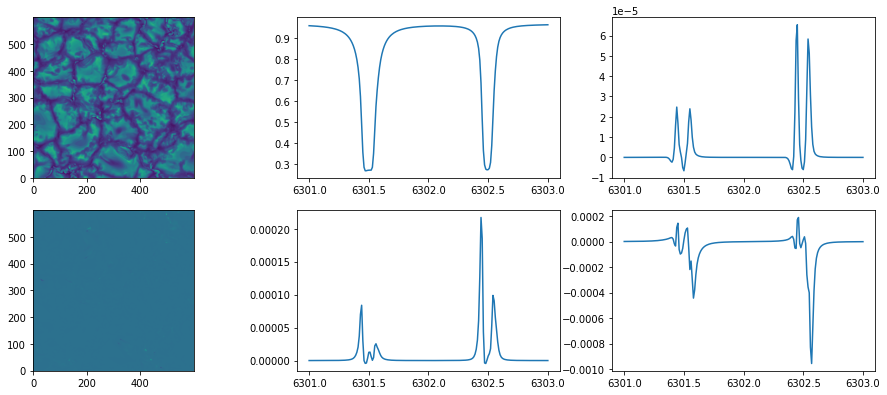

In [7]:
# Let's plot one example Stokes profile
i=250
j=130
plt.figure(figsize=[16,6.5])
plt.subplot(231)
plt.imshow(stokes[:,:,0,0],origin='lower')
plt.subplot(234)
plt.imshow(stokes[:,:,3,30],origin='lower')
plt.subplot(232)
plt.plot(ll,stokes[i,j,0])
plt.subplot(233)
plt.plot(ll,stokes[i,j,1])
plt.subplot(235)
plt.plot(ll,stokes[i,j,2])
plt.subplot(236)
plt.plot(ll,stokes[i,j,3])

### Ok what do you see here? Can someone comment on the shapes of the lines and the magnitudes of Stokes parameters? What do you think?

In [8]:
# Now we are going to try to invert that one spectra. 
# Inverting is fitting with M-E model.
# Let's try one line at the time. 

# What are the problems with inverting both lines simultaneously, can you discuss?
# We define wavelength regions. We will soon see what None refers to ;)

# We are inverting only the first one
ll = ll[:100]
regions = [[ll, None]]

# These are the lines
lines   = [6301]
# so now our code has wavelength grid and knows what to do

me = MilneEddington.MilneEddington(regions, lines, nthreads=1)

line::line: Initialized [6301.499500] ->  12 Zeeman components


In [9]:
# We learned yesterday that we need an estimate of the error uncertanties, we need to specify the noise
noise_level = 1.e-3
noise = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
noise += noise_level
noise[0] *= 10. #noise is typicaly larger for I, because of systematics - Discuss!

In [10]:
# We are going to get used to deal with number of pixels, so here are some new variables for you :)
nx = 1
ny = 1
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])

# This creates nx x ny clones of model_guess
models_guess  = me.repeat_model(model_guess, nx, ny)

# What are we fitting, one Stokes profile, but remember the form it has to go in (nx x ny x 4 x n_lambda)
to_fit = stokes[i,j,:,:100].reshape(1,1,4,100)
    
#
# This is where the inversion happens:
#
model_out, syn_out, chi2 = me.invert(models_guess, to_fit, noise, nRandom = 20, nIter=100, chi2_thres=1.0, verbose=False)


InvertMany: Processed -> 100%


In [11]:
# Let's, for the sanity's sake, print out the quantities:
print ('Model parameters :', model_out)
print ('Chi-squared = ',chi2)

Model parameters : [[[ 1.95840740e+01  1.67530227e+00  1.22718826e-01 -8.37910995e-02
    2.31632832e-02  3.88490791e+01  3.01246703e-01  2.18526825e-01
    7.47896373e-01]]]
Chi-squared =  [[0.92969996]]


$\chi^2$ is around 1, which is a good sign, the best way to see the fit, is to plot!

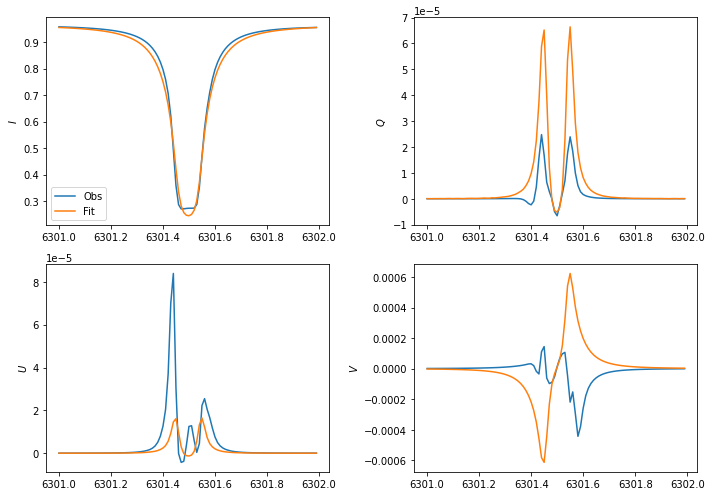

In [12]:
#test the plot
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,to_fit[0,0,0],label='Obs')
plt.plot(ll,syn_out[0,0,0],label='Fit')
plt.ylabel("$I$")
plt.legend()
plt.subplot(222)
plt.plot(ll,to_fit[0,0,1],label='Obs')
plt.plot(ll,syn_out[0,0,1],label='Fit')
plt.ylabel("$Q$")
plt.subplot(223)
plt.plot(ll,to_fit[0,0,2],label='Obs')
plt.plot(ll,syn_out[0,0,2],label='Fit')
plt.ylabel("$U$")
plt.subplot(224)
plt.plot(ll,to_fit[0,0,3],label='Obs')
plt.plot(ll,syn_out[0,0,3],label='Fit')
plt.ylabel("$V$")
plt.tight_layout()

#### Looks good! 

Now, spend some time fitting individual pixels and looking what happens there!


After you are dont with that, we can move on and fit a part of field of view (or the whole one, if you have a nice pc)

In [13]:
# First part is to make use of the parallel capabilities of modern processors and do this with
# multiple threads
me = MilneEddington.MilneEddington(regions, lines, nthreads=8)

pyMilne::dealloc: cleaning-up...


line::line: Initialized [6301.499500] ->  12 Zeeman components


In [18]:
%%time 
# This will tell us how much time we use

# Now we are going to select a region:
i = 0 # we start from here
j = 0 
nx = 600 # and take this big chunk
ny = 600

# The same as before
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
# Now we have 200 x 200 clones. In principle they don't have to be the same! 
models_guess  = me.repeat_model(model_guess, nx, ny)

# Select a Stokes subset to fit:
to_fit = stokes[i:i+nx,j:j+ny,:,:100].reshape(nx,ny,4,100)

# This is where the inversion happens, be mindful it will take some time
#
model_out, syn_out, chi2 = me.invert(models_guess, to_fit, noise, nRandom = 10, nIter=25, chi2_thres=1.0, verbose=False)

CPU times: user 51min 43s, sys: 2.04 s, total: 51min 45s
Wall time: 6min 32s


InvertMany: Processed -> 100%


In [19]:
print(model_out.shape)
print(chi2.shape)
#model_out = model_out.reshape(nx,ny,9)

(600, 600, 9)
(600, 600)


Well well well, look at that. Our parameters are also a cube now. And we even have a separate $\chi^2$ for each pixel! Looks great. Let's start by plotting $\chi^2$ map:

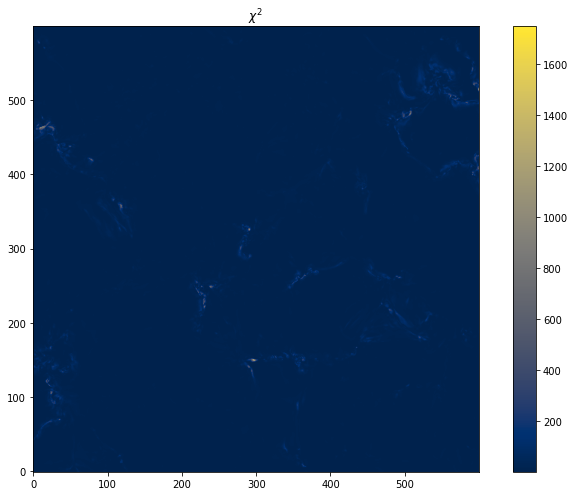

In [28]:
plt.figure(figsize=[10,7])
plt.imshow(chi2.T,cmap='cividis',origin='lower')
plt.title("$\chi^2$")
plt.colorbar()
plt.tight_layout()

Now, let's plot some parameter maps:

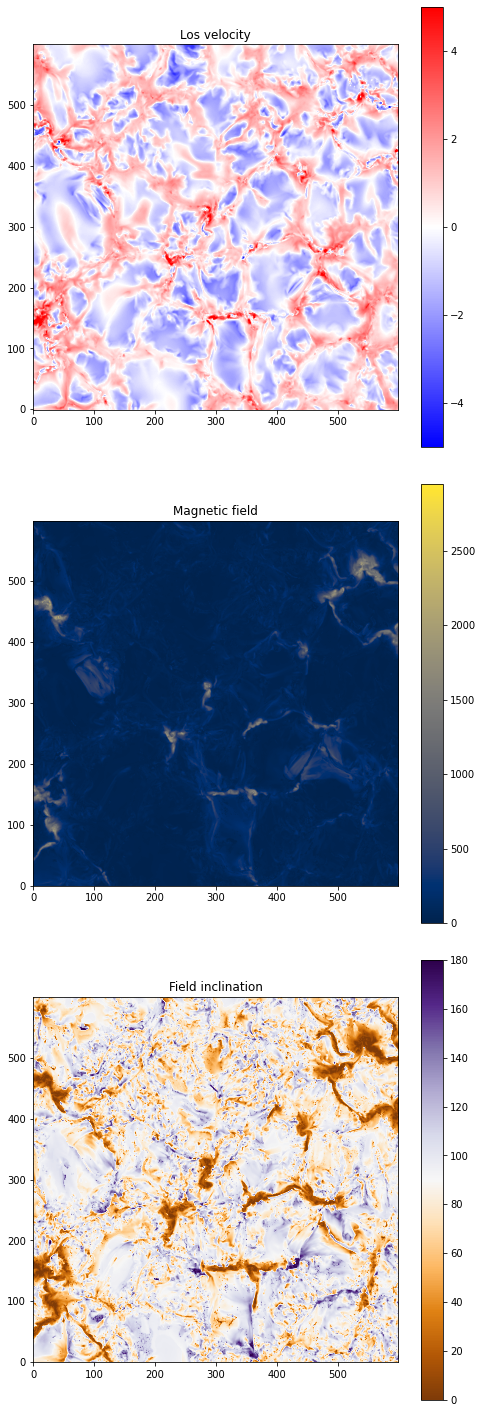

In [22]:
# The easiest sanity check for this is the velocity:
# Velocity is often normalized w.r.t the mean value 
plt.figure(figsize=[7,20])
plt.subplot(311)
plt.imshow(model_out[:,:,3].T,cmap='bwr',origin='lower',vmin=-5,vmax=5)
plt.title("Los velocity")
plt.colorbar()
plt.subplot(312)
plt.imshow(model_out[:,:,0].T,cmap='cividis',origin='lower')
plt.title("Magnetic field")
plt.colorbar()
plt.subplot(313)
plt.imshow(model_out[:,:,1].T*180./np.pi,cmap='PuOr',origin='lower')
plt.title("Field inclination")
plt.colorbar()

plt.tight_layout()

In [27]:
%%time 

from scipy.ndimage import gaussian_filter

model_out = gaussian_filter(model_out,(3,3,0))
model_out, syn_out, chi2 = me.invert(model_out, to_fit, noise, nRandom = 10, nIter=25, chi2_thres=1.0, verbose=False)
model_out = gaussian_filter(model_out,(2,2,0))
model_out, syn_out, chi2 = me.invert(model_out, to_fit, noise, nRandom = 10, nIter=35, chi2_thres=1.0, verbose=False)
model_out = gaussian_filter(model_out,(1,1,0))
model_out, syn_out, chi2 = me.invert(model_out, to_fit, noise, nRandom = 10, nIter=50, chi2_thres=1.0, verbose=False)

InvertMany: Processed -> 100%
InvertMany: Processed -> 100%


CPU times: user 2h 8min 5s, sys: 2.92 s, total: 2h 8min 8s
Wall time: 16min 7s


InvertMany: Processed -> 100%


### Compare with the original! 

Contrary to the fitting of the observed data, fitting synthetic data is interesting because it gives us ground truth. Let's discuss this a bit...

In [23]:
# Load the atmosphere
atmos = fits.open("/home/milic/data/muram_from_rebecca/muram_pole_atmos_61.fits")[0].data
atmos.shape

(12, 600, 600, 61)

In [24]:
# 12 stands for 12 physical parameters, 144 x 144 are NX and NY and 31 is for 31 depth points:
# Meaning of the paramters:
# 0 - log continuum optical depth 
# 1 - height (in cm)
# 2 - temperature 
# 7 - magnetic field
# 9 - los velocity (divide by -1E5)
# 10 - inclination 
# 11 - azimuth

print (atmos[0,0,0])

[-5.  -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3 -4.2 -4.1 -4.  -3.9 -3.8 -3.7
 -3.6 -3.5 -3.4 -3.3 -3.2 -3.1 -3.  -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3
 -2.2 -2.1 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9
 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5
  0.6  0.7  0.8  0.9  1. ]


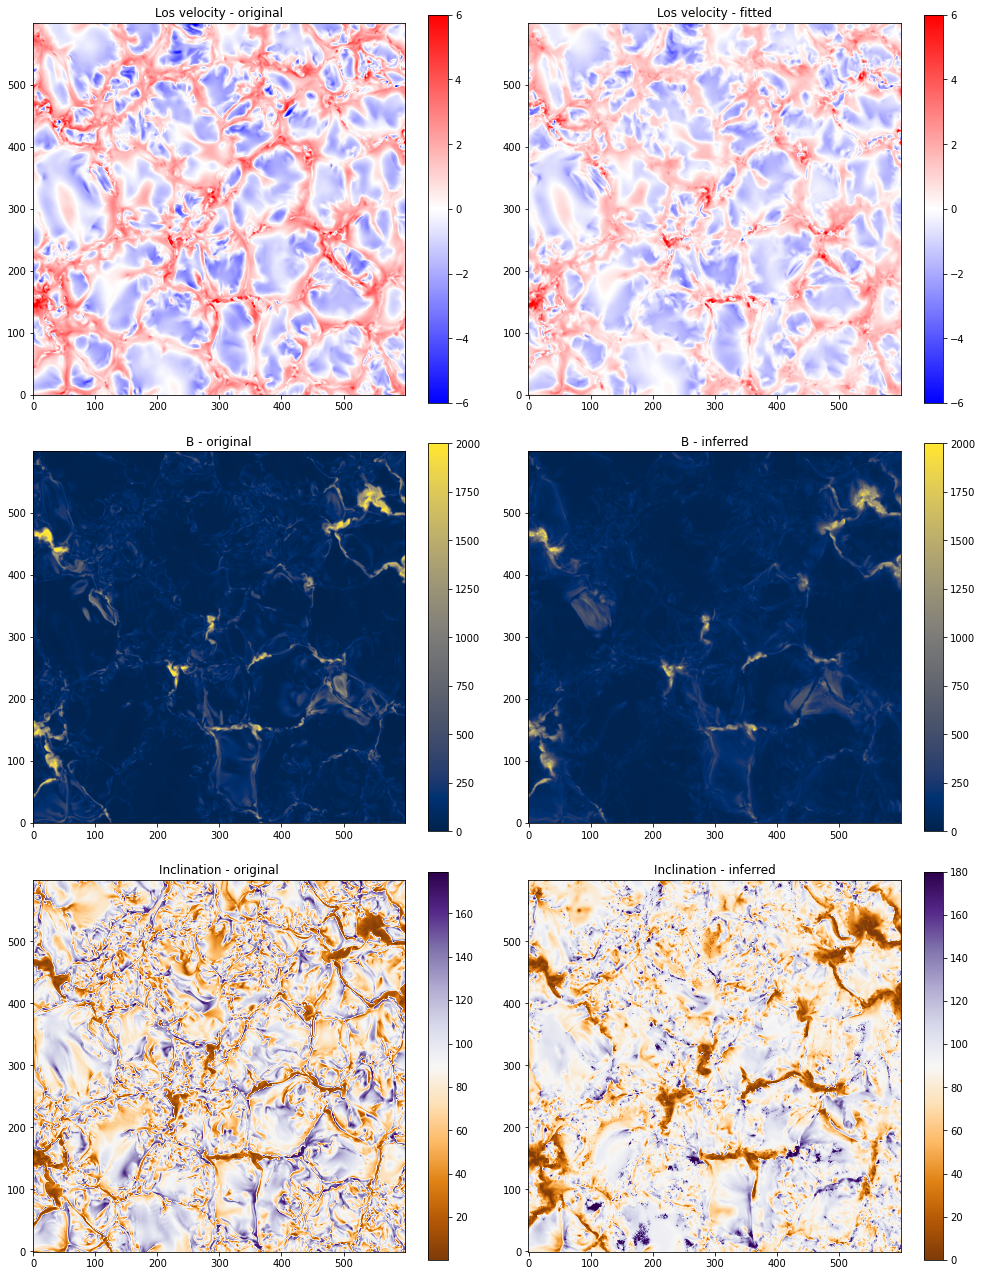

In [29]:
# Try changing the depth you are doing the comparison at:

depth = 40

plt.figure(figsize=[14,18])
plt.subplot(321)
plt.imshow(atmos[9,:,:,depth].T/(-1E5),cmap='bwr',origin='lower',vmin=-6,vmax=6)
plt.colorbar()
plt.title("Los velocity - original")
plt.subplot(322)
plt.imshow(model_out[:,:,3].T,cmap='bwr',origin='lower',vmin=-6,vmax=6)
plt.title("Los velocity - fitted")
plt.colorbar()

plt.subplot(323)
plt.imshow(atmos[7,:,:,depth].T,cmap='cividis',origin='lower',vmin=0,vmax=2000)
plt.colorbar()
plt.title("B - original")

plt.subplot(324)
plt.imshow(model_out[:,:,0].T,cmap='cividis',origin='lower',vmin=0,vmax=2000)
plt.title("B - inferred")
plt.colorbar()


plt.subplot(325)
plt.imshow(atmos[10,:,:,depth].T*180./np.pi,cmap='PuOr',origin='lower')
plt.colorbar()
plt.title("Inclination - original")
plt.subplot(326)
plt.imshow(model_out[:,:,1].T*180./np.pi,cmap='PuOr',origin='lower')
plt.title("Inclination - inferred")
plt.colorbar()
plt.tight_layout()

In [39]:
B_vert = atmos[7,:,:,depth] * np.cos(atmos[10,:,:,depth])


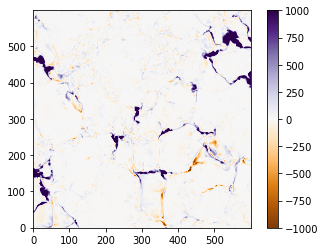

In [41]:
plt.imshow(B_vert.T,origin='lower',cmap='PuOr',vmin=-1000,vmax=1000)
plt.colorbar()

In [42]:
print (np.mean(B_vert))

32.50841450246135


33.468742


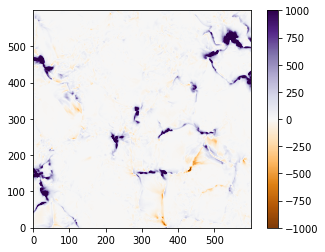

In [43]:
# What do we see? 
B_vert_inv = model_out[:,:,0] * np.cos(model_out[:,:,1])

plt.imshow(B_vert_inv.T,origin='lower',cmap='PuOr',vmin=-1000,vmax=1000)
plt.colorbar()

print (np.mean(B_vert_inv))

## Smooth out some data and go again! 

In [44]:
to_fit_smoothened = gaussian_filter(to_fit,(6,6,0,0))

In [45]:
model_out, syn_out, chi2 = me.invert(model_out, to_fit_smoothened, noise, nRandom = 10, nIter=50, chi2_thres=1.0, verbose=False)

InvertMany: Processed -> 100%


29.51377


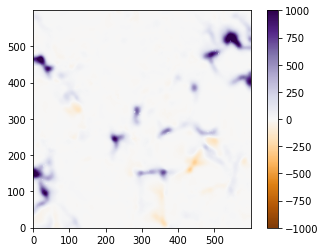

In [46]:
# What do we see? 
B_vert_inv_smooth = model_out[:,:,0] * np.cos(model_out[:,:,1])

plt.imshow(B_vert_inv_smooth.T,origin='lower',cmap='PuOr',vmin=-1000,vmax=1000)
plt.colorbar()

print (np.mean(B_vert_inv_smooth))

In [47]:
to_fit_smoothened = gaussian_filter(to_fit,(12,12,0,0))

In [48]:
model_out, syn_out, chi2 = me.invert(model_out, to_fit_smoothened, noise, nRandom = 10, nIter=50, chi2_thres=1.0, verbose=False)

InvertMany: Processed -> 100%


24.141197


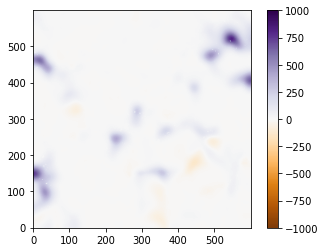

In [49]:
# What do we see? 
B_vert_inv_ssmooth = model_out[:,:,0] * np.cos(model_out[:,:,1])

plt.imshow(B_vert_inv_ssmooth.T,origin='lower',cmap='PuOr',vmin=-1000,vmax=1000)
plt.colorbar()

print (np.mean(B_vert_inv_ssmooth))

# Same but for slanted 

In [2]:
# Our good old packages for inversion, numerical manipulation and plotting...
import MilneEddington 
import numpy as np
import matplotlib.pyplot as plt

# You might remember this one, this allows us to load fits files into numpy arrays
from astropy.io import fits

In [4]:
#Load the data
stokes = fits.open('/home/milic/data/muram_from_rebecca/slanted/muram_pole_s_synth.fits')[0].data
stokes.shape

(600, 600, 4, 201)

In [5]:
qs = np.mean(stokes[:,:,0,-10:])
stokes /= qs

In [6]:
ll = np.arange(201)*0.01+6301.0

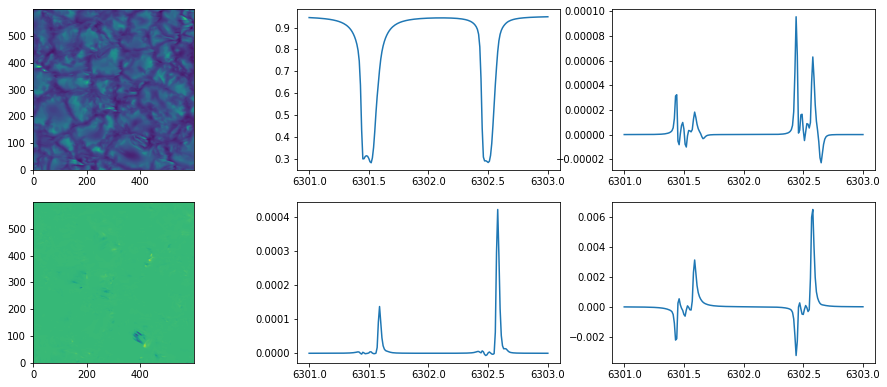

In [7]:
# Let's plot one example Stokes profile
i=250
j=130
plt.figure(figsize=[16,6.5])
plt.subplot(231)
plt.imshow(stokes[:,:,0,0],origin='lower')
plt.subplot(234)
plt.imshow(stokes[:,:,3,30],origin='lower')
plt.subplot(232)
plt.plot(ll,stokes[i,j,0])
plt.subplot(233)
plt.plot(ll,stokes[i,j,1])
plt.subplot(235)
plt.plot(ll,stokes[i,j,2])
plt.subplot(236)
plt.plot(ll,stokes[i,j,3])

In [10]:
# Now we are going to try to invert that one spectra. 
# Inverting is fitting with M-E model.
# Let's try one line at the time. 

# What are the problems with inverting both lines simultaneously, can you discuss?
# We define wavelength regions. We will soon see what None refers to ;)

# We are inverting only the first one
ll = ll[:100]
regions = [[ll, None]]

# These are the lines
lines   = [6301]
# so now our code has wavelength grid and knows what to do

me = MilneEddington.MilneEddington(regions, lines, nthreads=1)


# We learned yesterday that we need an estimate of the error uncertanties, we need to specify the noise
noise_level = 1.e-3
noise = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
noise += noise_level
noise[0] *= 10. #noise is typicaly larger for I, because of systematics - Discuss!
me = MilneEddington.MilneEddington(regions, lines, nthreads=8)

pyMilne::dealloc: cleaning-up...


line::line: Initialized [6301.499500] ->  12 Zeeman components
line::line: Initialized [6301.499500] ->  12 Zeeman components


In [11]:
%%time 
# This will tell us how much time we use

# Now we are going to select a region:
i = 0 # we start from here
j = 0 
nx = 600 # and take this big chunk
ny = 600

# The same as before
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
# Now we have 200 x 200 clones. In principle they don't have to be the same! 
models_guess  = me.repeat_model(model_guess, nx, ny)

# Select a Stokes subset to fit:
to_fit = stokes[i:i+nx,j:j+ny,:,:100].reshape(nx,ny,4,100)

# This is where the inversion happens, be mindful it will take some time
#
model_out, syn_out, chi2 = me.invert(models_guess, to_fit, noise, nRandom = 10, nIter=25, chi2_thres=1.0, verbose=False)

CPU times: user 50min 21s, sys: 7.32 s, total: 50min 28s
Wall time: 6min 27s


InvertMany: Processed -> 100%


7.397341


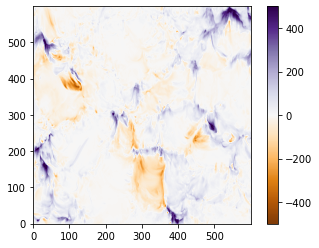

In [12]:
# What do we see? 
B_los_inv = model_out[:,:,0] * np.cos(model_out[:,:,1])
#B_los_inv /= np.cos(1.134)

plt.imshow(B_los_inv.T,origin='lower',cmap='PuOr',vmin=-500,vmax=500)
plt.colorbar()

print (np.mean(B_los_inv))

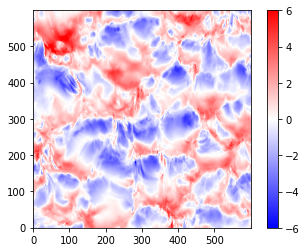

In [13]:
plt.imshow(model_out[:,:,3].T,cmap='bwr',origin='lower',vmin=-6,vmax=6)
plt.colorbar()

In [14]:
atmos_tilted = fits.open("/home/milic/data/muram_from_rebecca/muram_pole_slanted_tau.fits")[0].data

In [15]:
atmos_tilted.shape

(12, 600, 600, 80)

In [17]:
Blos = atmos_tilted[7] * np.cos(atmos_tilted[10])

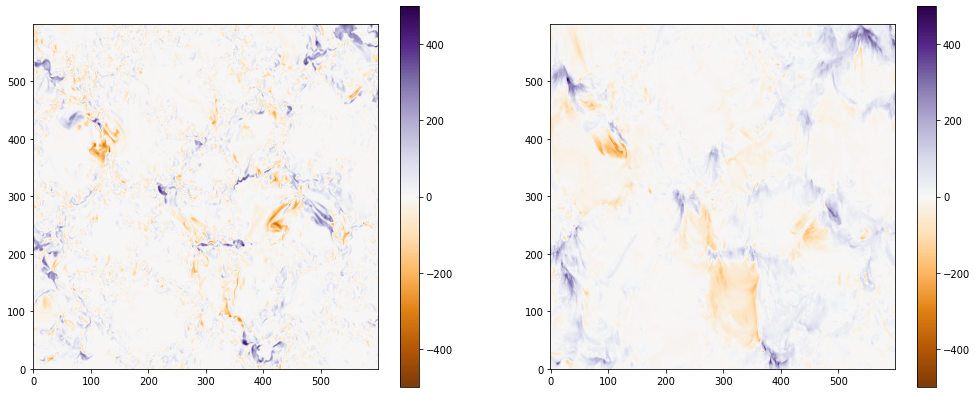

In [31]:
plt.figure(figsize=[17,7])
plt.subplot(121)
plt.imshow(Blos[:,:,-30].T,origin='lower',cmap='PuOr',vmin=-500,vmax=500)
plt.colorbar()
plt.subplot(122)
plt.imshow(B_los_inv.T,origin='lower',cmap='PuOr',vmin=-500,vmax=500)
plt.colorbar()

In [30]:
print(np.mean(Blos[:,:,-35].T/np.cos(1.134)))
print(np.mean(B_los_inv/np.cos(1.134)))

4.546517929948344
9.554648
